# Imports and Settings

In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier
from notebook_functions import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
col_idx = OrderedDict([(n.label, 0), ("temperature", 1), ("timepoint", 2), ("percent_live", 3)])

# Configure Variables

In [5]:
data = pd.read_csv("experiment_data/raw/Duke-YeastSTATES-Heat-LiveDeadClassification/processed_heat_data.csv")
color_channel_to_use = "YL1"
use_stain_in_AutoGater = False

point_1_that_defines_soa_line=(3.25, 4.5)
point_2_that_defines_soa_line=(4, 6.25)

# Begin Analysis

In [6]:
df = data.loc[data["stain"] == 1]

In [7]:
stain_cols = ["{}-A".format(color_channel_to_use), 
              "{}-H".format(color_channel_to_use),
              "{}-W".format(color_channel_to_use)]
all_features = n.morph_cols + stain_cols

if use_stain_in_AutoGater:
    features = all_features
else:
    features = n.morph_cols
    
print("Features that AutoGater will use: {}".format(features))

Features that AutoGater will use: ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']


In [8]:
df

,temperature,timepoint,stain,replicate,replicate_group,FSC-A,SSC-A,BL1-A,BL2-A,BL3-A,YL4-A,YL3-A,YL2-A,YL1-A,FSC-H,SSC-H,BL1-H,BL2-H,BL3-H,YL4-H,YL3-H,YL2-H,YL1-H,FSC-W,SSC-W,BL1-W,BL2-W,BL3-W,YL4-W,YL3-W,YL2-W,YL1-W,percent_live
0,25.0,0.0,1.0,1,560435687fc196e53fe75da8d68a4acf49c1c37f,6.02060,6.02060,3.84751,4.27752,4.18435,3.22737,0.00000,3.81617,4.33752,6.00101,6.00233,2.64345,2.89927,2.87622,2.22789,2.09691,2.57403,3.02036,3.00988,3.00988,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.77815,100.0
1,25.0,0.0,1.0,1,560435687fc196e53fe75da8d68a4acf49c1c37f,6.02060,6.02060,2.76864,3.20167,2.66558,0.00000,1.30103,2.48572,3.16376,5.99737,5.87715,2.44716,2.95182,2.59550,1.85126,1.90849,2.27416,2.78604,2.26482,2.28103,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.0
2,25.0,0.0,1.0,1,560435687fc196e53fe75da8d68a4acf49c1c37f,5.80063,5.57116,1.59106,2.22789,0.00000,1.32222,1.00000,1.47712,2.10721,5.74630,5.52755,2.00432,2.39270,2.44560,2.15836,1.80618,2.19312,2.42813,2.03743,2.01284,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.0
3,25.0,0.0,1.0,1,560435687fc196e53fe75da8d68a4acf49c1c37f,5.21132,4.86124,2.32634,3.26482,2.90091,2.34635,1.96379,3.12483,3.74772,5.21795,4.86391,2.29447,3.24969,3.01199,2.13354,1.98677,3.15564,3.74225,1.90849,1.86923,0.00000,1.23045,0.60206,0.00000,0.00000,1.11394,1.54407,100.0
4,25.0,0.0,1.0,1,560435687fc196e53fe75da8d68a4acf49c1c37f,5.95083,5.75293,2.42813,2.79588,2.91540,1.20412,0.00000,2.43457,3.03141,5.86277,5.67875,2.24551,2.70842,2.78675,1.95904,1.64345,2.32634,2.81690,2.13354,2.13354,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809995,65.0,6.0,1.0,1,1510cd950b126b84e155c13f98d066a367bfefe1,5.47728,5.45157,3.04766,4.23416,3.69249,3.16643,2.82086,4.20369,4.77485,5.44184,5.42521,3.04532,4.20455,3.61805,3.10823,2.77525,4.18432,4.74518,1.91908,1.92942,0.84510,1.65321,1.50515,1.04139,0.00000,1.69897,1.90849,0.0
3809996,65.0,6.0,1.0,1,1510cd950b126b84e155c13f98d066a367bfefe1,5.54773,5.73594,3.47958,4.40586,3.99458,3.30016,3.11727,4.37541,4.93406,5.50241,5.70544,3.37401,4.36524,3.96713,3.29092,3.02366,4.34526,4.89995,2.00432,2.00432,1.36173,1.89209,1.61278,1.25527,0.84510,1.94939,2.00432,0.0
3809997,65.0,6.0,1.0,1,1510cd950b126b84e155c13f98d066a367bfefe1,5.72146,6.01064,3.53377,4.42103,4.08030,3.41095,3.11227,4.32744,4.89026,5.59491,5.91048,3.40449,4.30833,3.96769,3.30728,2.96661,4.22914,4.80242,1.99564,2.05690,1.43136,1.96848,1.74036,1.41497,0.00000,1.91908,1.99564,0.0
3809998,65.0,6.0,1.0,1,1510cd950b126b84e155c13f98d066a367bfefe1,5.83877,6.02060,3.58252,4.45568,4.16584,3.24797,3.12905,4.31500,4.89326,5.61756,5.92140,3.40226,4.25305,3.98439,3.14953,2.92942,4.14959,4.72753,2.04922,2.08279,1.50515,1.96379,1.74036,1.27875,0.00000,1.89209,2.03743,0.0


In [13]:
geo_means = df.groupby(["temperature", "timepoint"], as_index=False).mean()
geo_means

,temperature,timepoint,stain,replicate,FSC-A,SSC-A,BL1-A,BL2-A,BL3-A,YL4-A,YL3-A,YL2-A,YL1-A,FSC-H,SSC-H,BL1-H,BL2-H,BL3-H,YL4-H,YL3-H,YL2-H,YL1-H,FSC-W,SSC-W,BL1-W,BL2-W,BL3-W,YL4-W,YL3-W,YL2-W,YL1-W,percent_live
0,25.0,0.0,1.0,1,5.636376,5.445559,1.684712,1.937603,1.769984,1.146802,0.949627,1.382711,1.612622,5.563155,5.382471,2.262269,2.790051,2.838702,2.302748,1.926870,2.550233,2.901792,1.999375,2.009180,0.009482,0.134389,0.176736,0.005747,0.002150,0.047465,0.314948,100.000000
1,25.0,0.5,1.0,1,5.657026,5.469598,1.697614,1.938086,1.809320,1.149448,0.948646,1.397996,1.626523,5.583883,5.402823,2.262024,2.790504,2.839955,2.303041,1.925798,2.550899,2.907877,2.003313,2.016664,0.008921,0.132125,0.174879,0.005346,0.002072,0.042240,0.331774,100.000000
2,25.0,1.0,1.0,1,5.682156,5.482511,1.711641,1.968339,1.827726,1.138925,0.948626,1.396423,1.632343,5.609469,5.414313,2.263605,2.784289,2.834583,2.293620,1.921099,2.537744,2.893834,2.007212,2.022555,0.007675,0.121637,0.166692,0.004342,0.001005,0.035984,0.310788,100.000000
3,25.0,2.0,1.0,1,5.702142,5.484252,1.727416,1.984927,1.848712,1.120397,0.936959,1.433323,1.681449,5.631220,5.416377,2.250993,2.769468,2.819082,2.281621,1.915337,2.531954,2.889405,2.011128,2.024290,0.005310,0.103864,0.142980,0.003383,0.001024,0.027896,0.310025,100.000000
4,25.0,3.0,1.0,1,5.715210,5.475728,1.741665,1.995912,1.839690,1.103011,0.923823,1.410191,1.692831,5.645662,5.408111,2.233330,2.734798,2.790299,2.245785,1.894778,2.471507,2.821257,2.015738,2.024016,0.003246,0.071476,0.104687,0.002025,0.000782,0.019075,0.194520,85.443333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,65.0,2.0,1.0,1,5.529659,5.667066,3.135996,4.200968,3.747690,3.016842,2.883795,4.159004,4.727115,5.425890,5.598394,3.030621,4.113833,3.661846,2.991920,2.833932,4.097157,4.662757,1.979585,2.000142,0.711597,1.750238,1.548732,0.657354,0.411129,1.758540,1.911437,0.000000
60,65.0,3.0,1.0,1,5.535425,5.677675,3.180603,4.220641,3.784124,3.050673,2.907500,4.177858,4.743209,5.425971,5.607883,3.069829,4.125728,3.692723,3.016526,2.848626,4.107716,4.671462,1.986081,2.007207,0.809588,1.767009,1.575412,0.708882,0.420845,1.772586,1.924165,0.000000
61,65.0,4.0,1.0,1,5.530980,5.676035,3.211232,4.238200,3.816355,3.066505,2.917507,4.183586,4.747155,5.422092,5.606870,3.099221,4.145288,3.723201,3.031669,2.859940,4.115650,4.678576,1.985816,2.006608,0.874501,1.772490,1.591073,0.742959,0.458753,1.771890,1.921448,0.000000
62,65.0,5.0,1.0,1,5.531524,5.678592,3.232897,4.240877,3.830997,3.080383,2.922203,4.184201,4.747666,5.420882,5.608518,3.118819,4.145463,3.735845,3.039166,2.859186,4.112343,4.674755,1.988847,2.010185,0.920962,1.779154,1.602816,0.754571,0.452108,1.778776,1.928231,0.000000


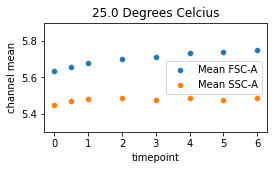

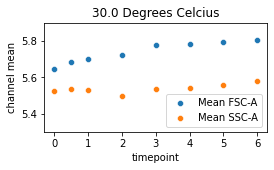

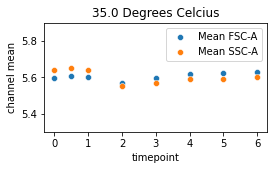

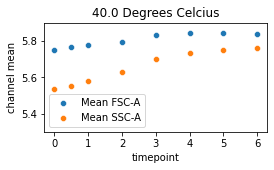

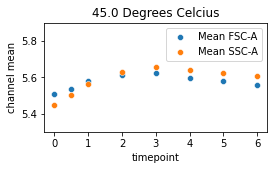

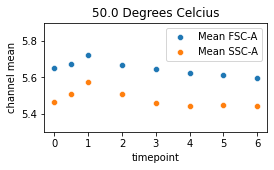

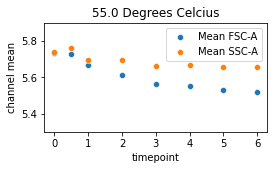

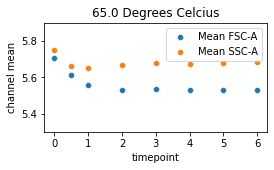

In [69]:
for temp in geo_means["temperature"].unique():
    count = count+1
    fig = plt.figure(figsize=(4, 2))
    temp_df = geo_means.loc[geo_means["temperature"] == temp]
    sns.scatterplot(data=temp_df, x="timepoint", y="FSC-A", label="Mean FSC-A")
    sns.scatterplot(data=temp_df, x="timepoint", y="SSC-A", label="Mean SSC-A")
    plt.ylim(5.3, 5.9)
    plt.legend()
    plt.ylabel("channel mean")
    plt.title("{} Degrees Celcius".format(temp))

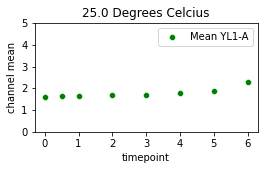

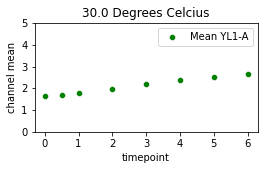

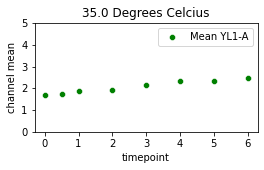

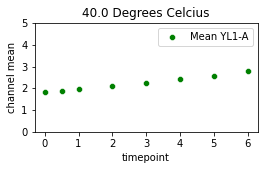

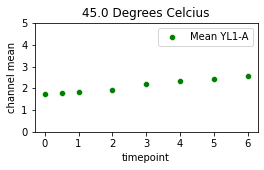

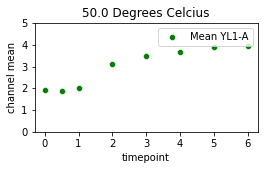

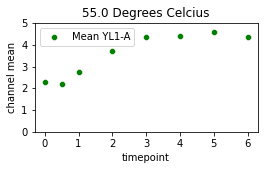

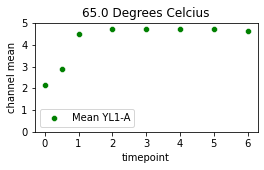

In [49]:
for temp in geo_means["temperature"].unique():
    fig = plt.figure(figsize=(4, 2))
    temp_df = geo_means.loc[geo_means["temperature"] == temp]
    sns.scatterplot(data=temp_df, x="timepoint", y="YL1-A", label="Mean YL1-A", color="g")
    plt.ylim(0, 5)
    plt.legend()
    plt.ylabel("channel mean")
    plt.title("{} Degrees Celcius".format(temp))

In [ ]:
count = 0
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))
for temp in geo_means["temperature"].unique():
#     fig = plt.figure(figsize=(4, 2))

    temp_df = geo_means.loc[geo_means["temperature"] == temp]
    sns.scatterplot(data=temp_df, x="timepoint", y="FSC-A", label="Mean FSC-A", ax=axes[count][0])
    sns.scatterplot(data=temp_df, x="timepoint", y="SSC-A", label="Mean SSC-A", ax=axes[count][0])
    plt.ylim(5.3, 5.9)
    
    sns.scatterplot(data=temp_df, x="timepoint", y="YL1-A", label="Mean YL1-A", ax=axes[count][1], color="g")
    plt.ylim(0, 5)

    count = count+1
    plt.legend()
    plt.ylabel("channel mean")
    plt.title("{} Degrees Celcius".format(temp))

In [9]:
df_with_rfc_labels, X, Y = generate_rf_labels_from_conditions(df, features,
                                                              live_conditions=[{'temperature': 25.0,
                                                                               'timepoint': 6.0},
                                                                               {'temperature': 30.0,
                                                                                'timepoint': 6.0},
                                                                               {'temperature': 35.0,
                                                                                'timepoint': 6.0}], 
                                                              dead_conditions=[{'temperature': 65.0,
                                                                                'timepoint': 6.0},
                                                                               {'temperature': 55.0,
                                                                                'timepoint': 6.0}])

Conditions designated as Live: [{'temperature': 25.0, 'timepoint': 6.0}, {'temperature': 30.0, 'timepoint': 6.0}, {'temperature': 35.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'temperature': 65.0, 'timepoint': 6.0}, {'temperature': 55.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 10:20:48
Starting Classification training...
Training time was: 23.36 seconds
Testing time was: 2.69 seconds
Prediction time of untested data was: 41.15937280654907
Run finished at 10:22:04. Total run time = 76.08 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^





Model Boosting took 694.1574370861053 seconds
Training Accuracy = 87.77%
Counter({1: 1451050, 0: 468950})
Instructions for updating:
Please use `model.predict()` instead.


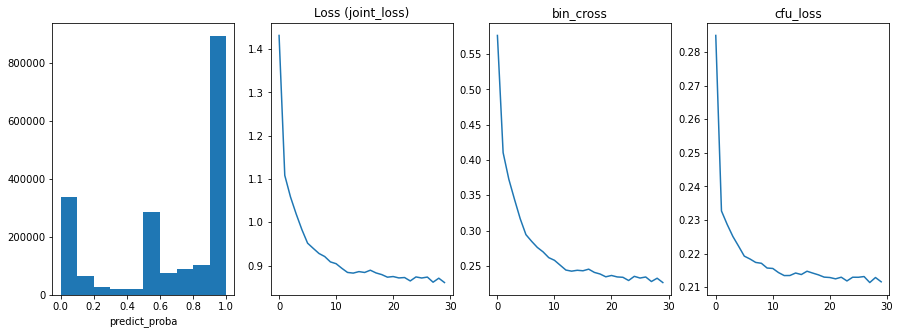

In [10]:
condition_results, preds_and_labels = run_model(model_function=booster_model_v2, lr=0.001,
                                                loss = joint_loss_wrapper(3), 
                                                metrics = [bin_cross, cfu_loss],
                                                X = X, Y = Y, epochs = 30, batch_size = 2048,
                                                verbose = False, shuffle = True, plot_type="line")

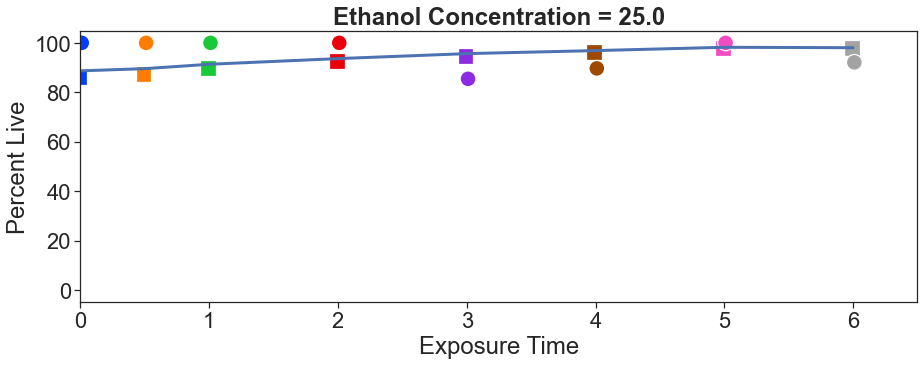

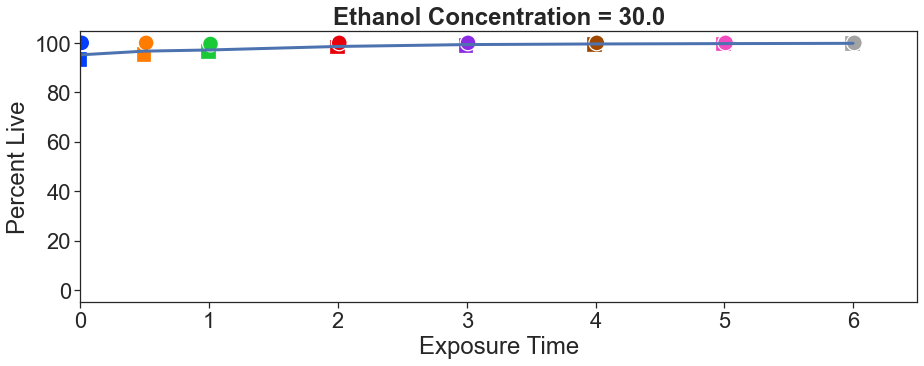

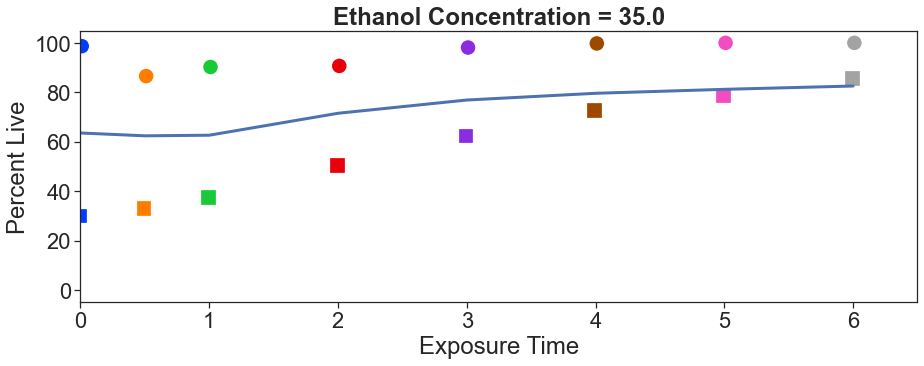

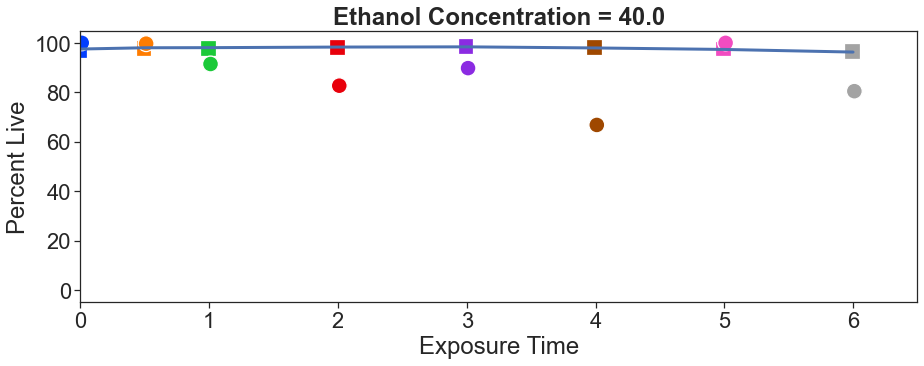

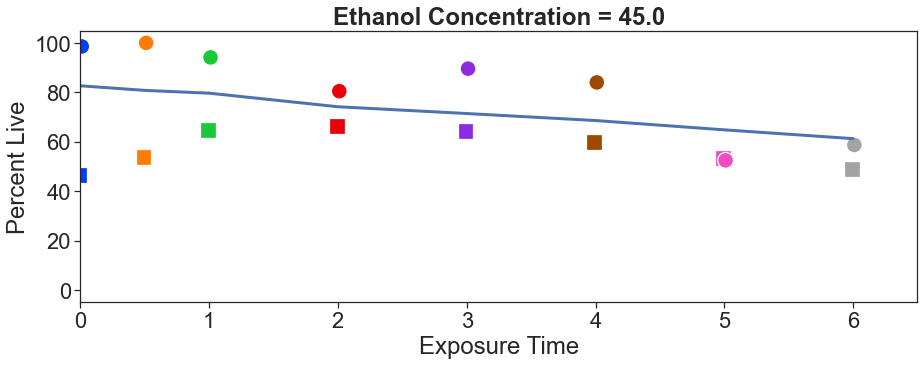

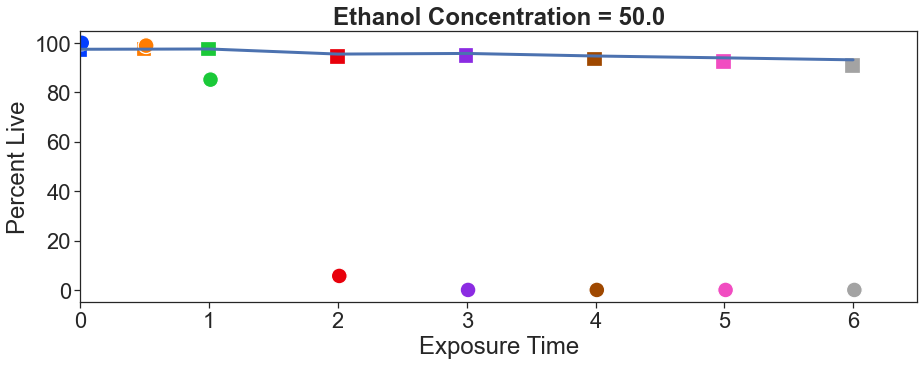

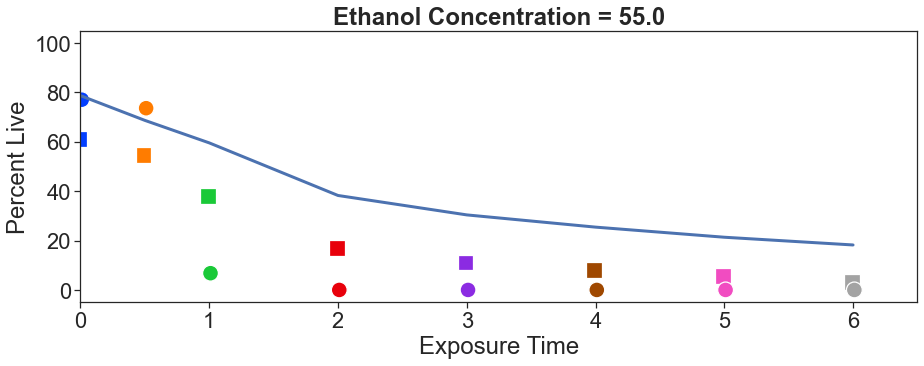

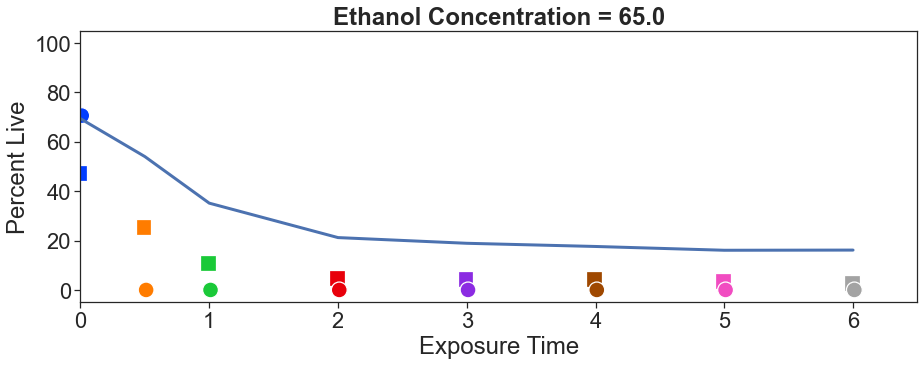

In [11]:
plot_per_cond(condition_results)


In [12]:
if use_stain_in_AutoGater:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels)
else:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels,
                                append_df_cols=stain_cols)

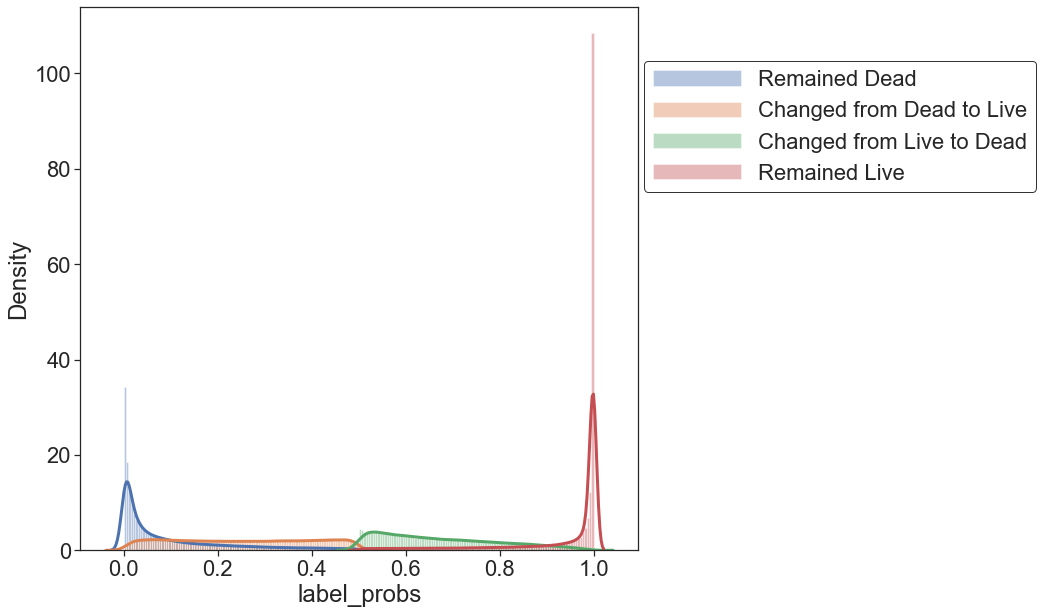

In [13]:
plot_prob_changes(run_info, None)

In [14]:
kde_df = get_conc_df_with_kde_values(run_info,
                                     conc="all",
                                     features=all_features,
                                     cc="{}-H".format(color_channel_to_use))

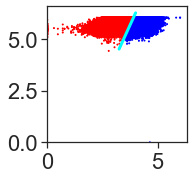

Percent of AutoGater live predictions that are left of the SOA dashed line: 88.1


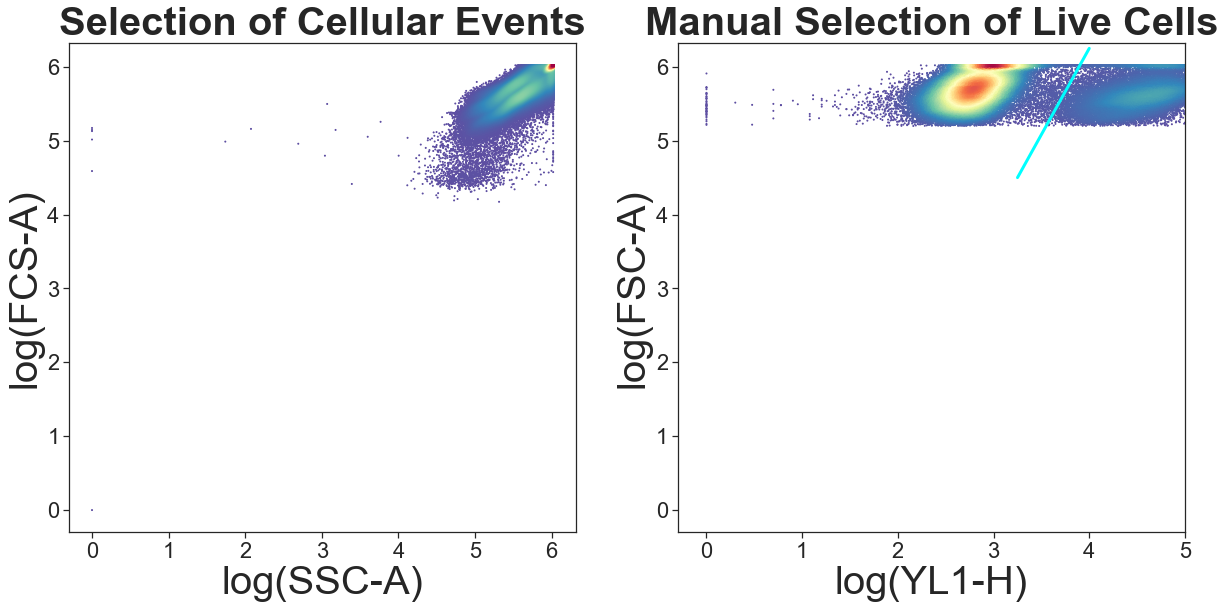

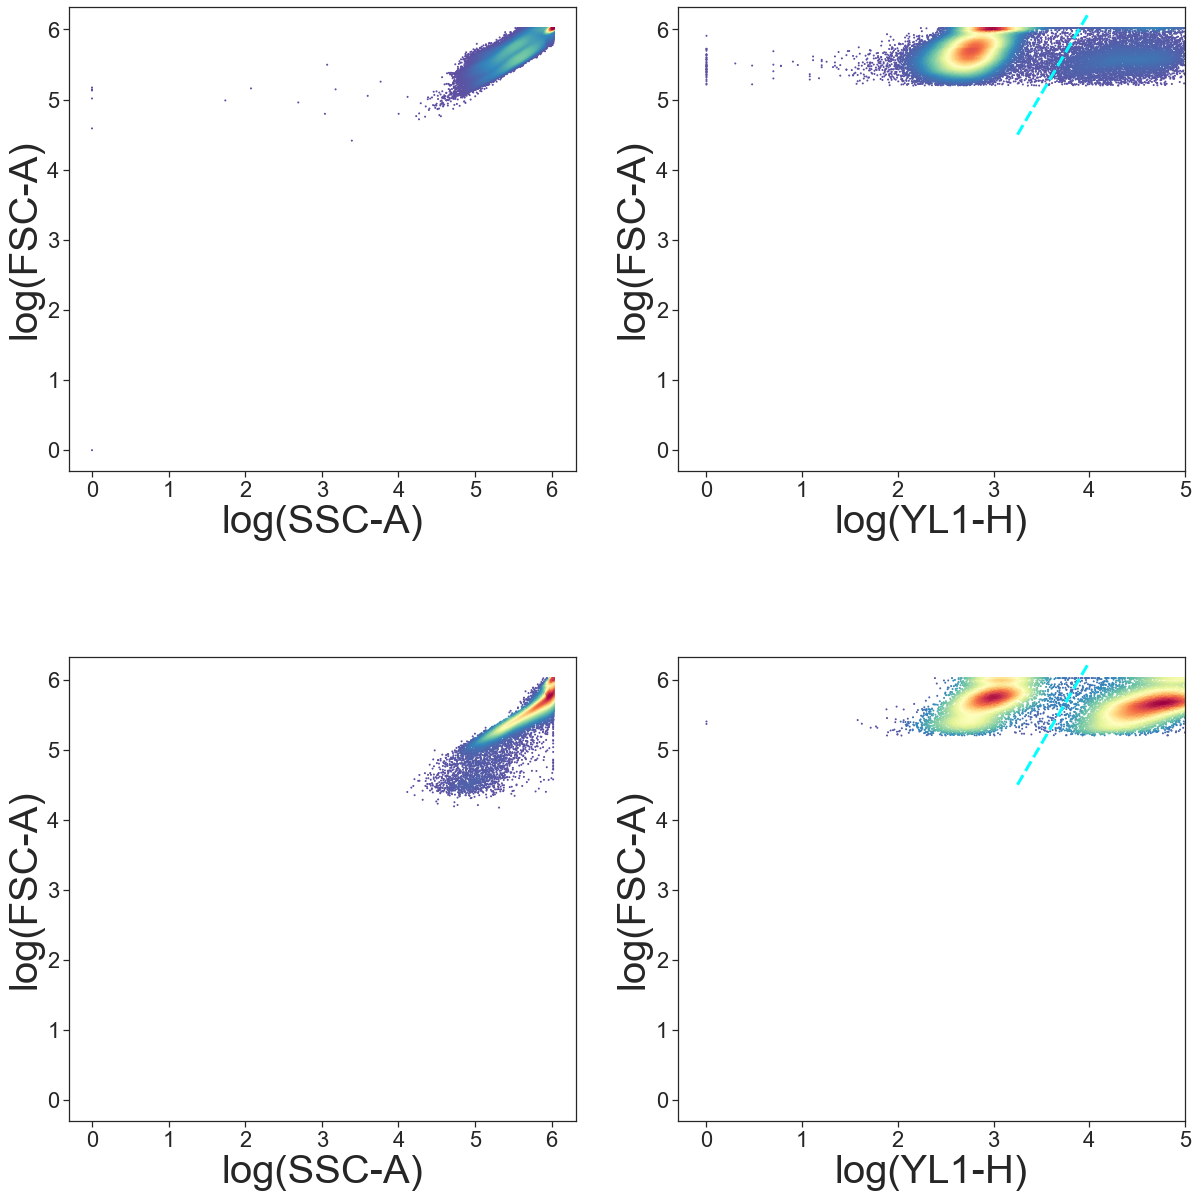

In [15]:
final_df = kde_scatter(kde_df, cc="{}-H".format(color_channel_to_use), logged=True,
                       fraction_of_points_based_on_kde=0.9,
                       point_1_that_defines_line=point_1_that_defines_soa_line, 
                       point_2_that_defines_line=point_2_that_defines_soa_line,
                       cmap="Spectral_r", pred_col="nn_preds")

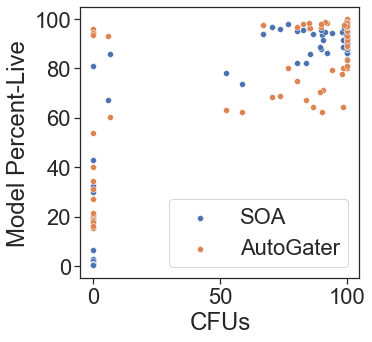

R-Squared between CFUs and State-of-the-Art predicted Percent-Live: 0.64
R-Squared between CFUs and AutoGater predicted Percent-Live: -0.39
R-Squared between CFUs and RFC predicted Percent-Live: 0.06



In [16]:
summary_table = summary_table_of_results(final_df)

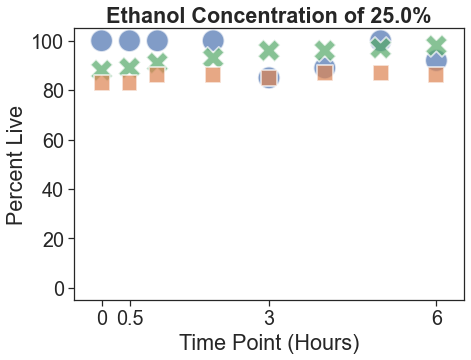

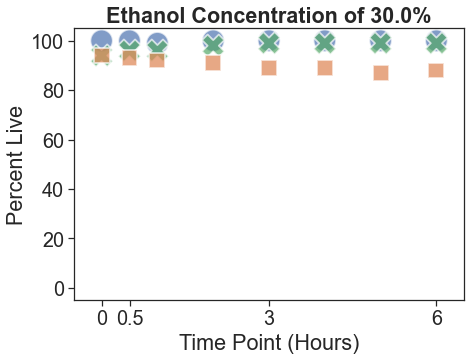

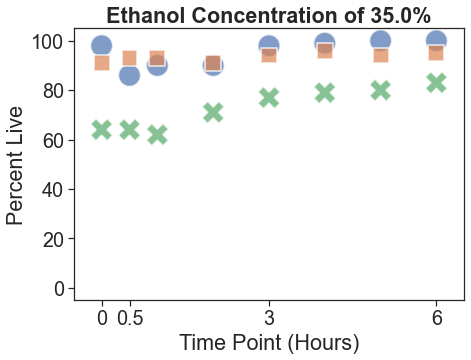

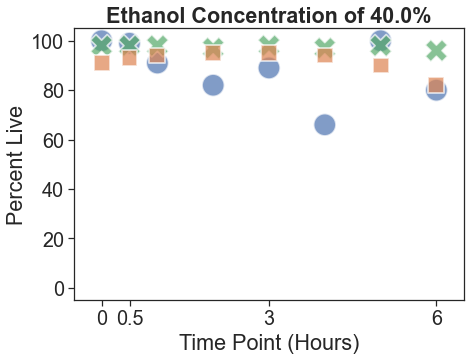

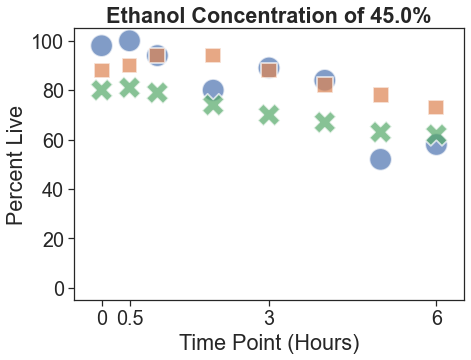

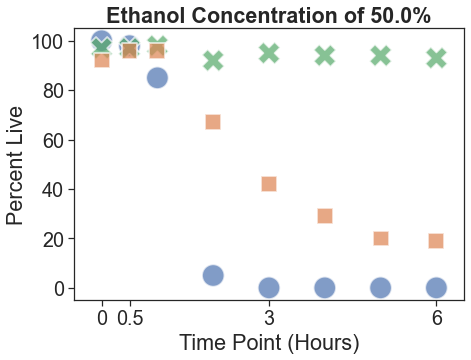

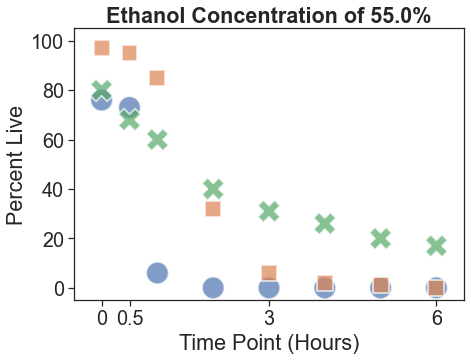

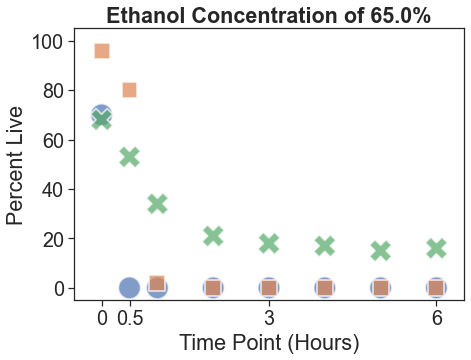

In [17]:
percent_live_comparison_plot(summary_table, legend=False)

In [18]:
# summary_table_2 = summary_table.copy()
# summary_table_2.drop(columns="AutoGater", inplace=True)
# summary_table_2.rename(columns={"Weakly Supervised Model (RF)": "AutoGater"}, inplace=True)


In [19]:
# percent_live_comparison_plot(summary_table_2)